In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ranitsarkar01_yulu_bike_sharing_data_path = kagglehub.dataset_download('ranitsarkar01/yulu-bike-sharing-data')

print('Data source import complete.')


100%|██████████| 130k/130k [00:00<00:00, 60.9MB/s]

Extracting files...
Data source import complete.


# Problem Statement

1. Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
2. How well do the identified variables describe the demand for electric cycles?

# Report Structure

1. Preparing Data
2. Basic statistics
3. Data Cleaning
5. Graphical Summary
6. Profiling & Advance Statistics
7. Business Insights
8. Recommendations

# 1. Preparing Data

In [2]:
%pip install pingouin scikit_posthocs arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 25.0 MB/s eta 0:00:00


In [3]:
from calendar import month_abbr
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from arch.unitroot import ZivotAndrews
from scikit_posthocs import posthoc_dunn
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ranitsarkar01/yulu-bike-sharing-data")
path

'/kaggle/input/yulu-bike-sharing-data'

In [5]:
!ls '/kaggle/input/yulu-bike-sharing-data'

yulu_bike_sharing_dataset.csv


In [6]:
yulu = pd.read_csv(path + '/yulu_bike_sharing_dataset.csv')

In [7]:
import warnings
warnings.filterwarnings('ignore')

# 2. Basic statistics

## In this section, we'll try to identify —


1.   Number of rows and columns of data.
2.   Data type of each column, non-null values in each column and memory usage by the dataset.
3.   How data looks like, by taking sample of 5 rows out of it.
4.   Distinct values in each column.
5.   If dataset contains duplicated rows.

In [8]:
# Number of rows and columns of data.
yulu.shape

(10886, 12)

In [9]:
# Data type of each column, non-null values in each column and memory usage by the dataset.
yulu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [10]:
# How data looks like, by taking sample out of it.
yulu.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
9753,2012-10-10 18:00:00,4,0,1,2,22.96,26.515,49,11.0014,57,787,844
9924,2012-10-17 21:00:00,4,0,1,1,18.86,22.725,82,12.9980,28,301,329
8770,2012-08-07 19:00:00,3,0,1,2,31.16,36.365,66,7.0015,104,506,610
9901,2012-10-16 22:00:00,4,0,1,1,16.40,20.455,71,6.0032,18,163,181
2977,2011-07-12 23:00:00,3,0,1,1,31.98,35.605,52,0.0000,20,59,79


In [11]:
# Distinct values in each column
yulu.nunique().rename('Distinct Values').reset_index().T.style.hide(axis='columns')

index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
Distinct Values,10886,4,2,2,4,49,60,89,28,309,731,822


In [12]:
# If dataset contains duplicated rows.
yulu.duplicated().sum()

np.int64(0)

## Statistical Summary —

In [13]:
yulu.datetime = pd.to_datetime(yulu.datetime)

# Renaming 'count' column to 'total_rentals'
yulu.rename(columns={"count": "total_rentals"}, inplace=True)

statistics = yulu.copy()

seasons = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
statistics["season"] = statistics["season"].map(seasons)

working = {1: "working", 0: "non-working"}
statistics["workingday"] = statistics["workingday"].map(working)

holiday = {1: "holiday", 0: "non-holiday"}
statistics["holiday"] = statistics["holiday"].map(holiday)

weather = {
    1: "clear or cloudy",
    2: "misty and cloudy",
    3: "thunderstorm, light rain or snow",
    4: "fog, heavy rain, ice pellets or snow",
}
statistics["weather"] = statistics["weather"].map(weather)

# Seperating date from time.
statistics["date"] = pd.to_datetime(yulu["datetime"]).dt.date
statistics["time"] = pd.to_datetime(yulu["datetime"]).dt.time
statistics.drop(columns="datetime", inplace=True)

# Nominal Variables — Holiday, Season, Weather, Working Day
nominal_columns = ["holiday", "season", "weather", "workingday"]

for column in nominal_columns:
    statistics[column] = statistics[column].astype("category")

In [14]:
# For numerical column.
describe = statistics.describe().T
describe["range"] = describe["max"] - describe["min"]
describe["mode"] = statistics.mode().iloc[0]
describe["IQR"] = describe["75%"] - describe["25%"]
describe[
    ["count", "range", "mean", "mode", "std", "min", "25%", "50%", "75%", "max", "IQR"]
].style.format("{:.2f}")

,count,range,mean,mode,std,min,25%,50%,75%,max,IQR
temp,10886.00,40.18,20.23,14.76,7.79,0.82,13.94,20.50,26.24,41.00,12.30
atemp,10886.00,44.70,23.66,31.06,8.47,0.76,16.66,24.24,31.06,45.45,14.39
humidity,10886.00,100.00,61.89,88.00,19.25,0.00,47.00,62.00,77.00,100.00,30.00
windspeed,10886.00,57.00,12.80,0.00,8.16,0.00,7.00,13.00,17.00,57.00,10.00
casual,10886.00,367.00,36.02,0.00,49.96,0.00,4.00,17.00,49.00,367.00,45.00
registered,10886.00,886.00,155.55,3.00,151.04,0.00,36.00,118.00,222.00,886.00,186.00
total_rentals,10886.00,976.00,191.57,5.00,181.14,1.00,42.00,145.00,284.00,977.00,242.00


In [15]:
# For categorical columns.
categorical = statistics.select_dtypes(exclude=np.number).describe().T
categorical["percentage"] = 100 * categorical["freq"] / categorical["count"]
categorical.style.format({"percentage": "{:.2f}%"})

,count,unique,top,freq,percentage
season,10886,4,winter,2734,25.11%
holiday,10886,2,non-holiday,10575,97.14%
workingday,10886,2,working,7412,68.09%
weather,10886,4,clear or cloudy,7192,66.07%
date,10886,456,2012-12-19,24,0.22%
time,10886,24,16:00:00,456,4.19%


In [16]:
statistics[statistics.holiday == 'holiday'].groupby(statistics.date).count().holiday.count()

np.int64(13)

### Summary

- $97\%$ of the rentals have been made on non-holidays but that is because there are only $13$ holidays.
- $66\%$ of the rentals have been made in clear or cloudy weather.
- $68\%$ of the rentals have been made on a working day.

# 3. Data Cleaning

## In this section —

1. Find categorical and numerical columns and convert them.
2. Relabeling numerics to more readable values in categorical columns.
3. Missing Values
4. Detecting and Treating Outliers.

In [17]:
# Renaming 'count' column to 'total_rentals'
yulu.rename(columns={"count": "total_rentals"}, inplace=True)

yulu.datetime = pd.to_datetime(yulu.datetime)

# Nominal Variables — Holiday, Season, Weather, Working Day
nominal_columns = ["holiday", "season", "weather", "workingday"]

# Relabeling holiday column.
holiday = {1: "holiday", 0: "non-holiday"}
yulu.holiday = yulu.holiday.map(holiday)

# Relabeling seasons column.
seasons = {1: "spring", 2: "summer", 3: "autumn", 4: "winter"}
yulu.season = yulu.season.map(seasons)

# Relabeling weather column.
weather = {
    1: "clear or cloudy",
    2: "misty and cloudy",
    3: "thunderstorm, light rain or snow",
    4: "fog, heavy rain, ice pellets or snow",
}
yulu.weather = yulu.weather.map(weather)

# Relabeling workingday column.
working = {1: "working", 0: "non-working"}
yulu.workingday = yulu.workingday.map(working)

for column in nominal_columns:
    yulu[column] = yulu[column].astype("category")

In [18]:
# Verifying the changes.
yulu.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
8076,2012-06-16 21:00:00,summer,non-holiday,non-working,misty and cloudy,26.24,31.060,50,15.0013,98,192,290
400,2011-01-18 16:00:00,spring,non-holiday,working,misty and cloudy,9.02,11.365,87,12.9980,0,61,61
7822,2012-06-06 07:00:00,summer,non-holiday,working,clear or cloudy,20.50,24.240,72,0.0000,16,531,547
2431,2011-06-09 05:00:00,summer,non-holiday,working,misty and cloudy,28.70,33.335,84,0.0000,1,19,20
95,2011-01-05 04:00:00,spring,non-holiday,working,clear or cloudy,9.84,11.365,48,15.0013,0,2,2


## Missing Values

In [19]:
# How many years of data we have?
yulu.datetime.dt.year.unique().tolist()

[2011, 2012]

In [20]:
# Subtracting first and last date to find range of days.
(yulu.datetime.dt.date.max() - yulu.datetime.dt.date.min()).days, len(yulu.datetime.dt.date.unique())

(718, 456)

In [21]:
# How data is divided for a day — hourly
yulu.groupby(yulu.datetime.dt.date).count().datetime.iloc[0]

np.int64(24)

In [22]:
# Comparing available data with actual numbers.
456 * 24, yulu.shape[0]

(10944, 10886)

### So we discovered missing data at two levels $-$
- Not all the dates are available to us, to be precise, $36.5\%$ or $262$ days of data is missing
- Data is not available for every hour of every date, to be precise, $58$ hours for available dates.
- If there is no rental at particular hour/day it hasn't been logged.

## Outlier Detection and Treatment

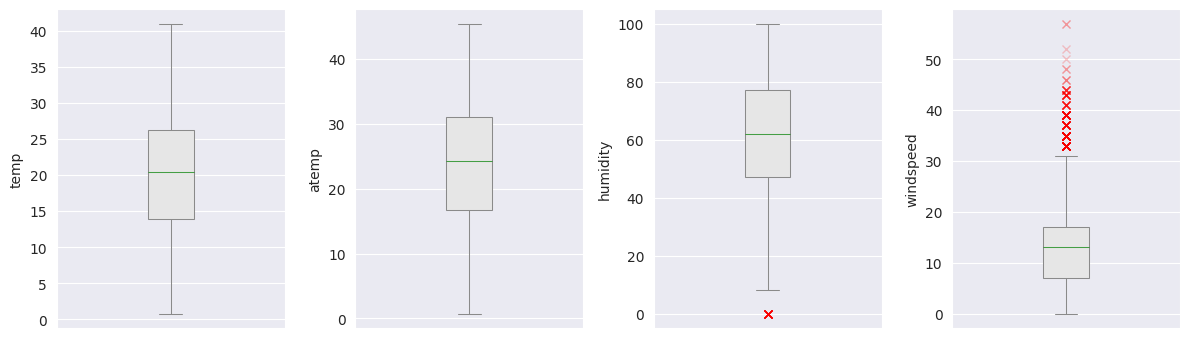

In [23]:
sns.set_style("darkgrid")

columns = ['temp', 'atemp', 'humidity', 'windspeed']
fig, axes = plt.subplots(1, len(columns), figsize=(12, 3.5))

for idx, ax in enumerate(axes.flat):
    sns.boxplot(
        y = columns[idx], data = yulu, showcaps = True, width = 0.2, ax=ax,
        medianprops = dict(color='g', alpha=0.7), color = "0.9", linewidth = 0.75,
        flierprops = dict(marker='x', markeredgecolor='r', alpha=0.2)
    )

plt.tight_layout()
plt.show()

In [24]:
def find_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return (lower_bound, upper_bound), outliers

In [25]:
_, humidity_outliers = find_outliers(yulu, 'humidity')
humidity_outliers.datetime.dt.date.unique()

array([datetime.date(2011, 3, 10)], dtype=object)

In [26]:
humidity_outliers.datetime.dt.date.unique().tolist()[0], humidity_outliers.shape[0], \
                                                         round(100 * humidity_outliers.shape[0] / yulu.shape[0], 3)

(datetime.date(2011, 3, 10), 22, 0.202)

If we closely observe the outlier on the humidity graph, we'll discover that these are rentals from the same day, the second Thursday of March $2011$, when humidity was $0\ g/m^3$, and they account for $0.202\%$ of rentals.

In [27]:
_, windspeed_outliers = find_outliers(yulu, 'windspeed')
windspeed_outliers.sample(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
1582,2011-04-11 20:00:00,summer,non-holiday,working,clear or cloudy,27.88,31.820,57,35.0008,44,122,166
10540,2012-12-05 14:00:00,winter,non-holiday,working,clear or cloudy,19.68,23.485,33,32.9975,39,179,218
5817,2012-01-17 14:00:00,spring,non-holiday,working,clear or cloudy,18.04,21.970,62,32.9975,12,120,132


In [28]:
windspeed_outliers.shape[0], round(100 * windspeed_outliers.shape[0] / yulu.shape[0], 3)

(227, 2.085)

In the windspeed graph, wind speeds of more than $32\ mph$ are plotted as outliers, and they account for $2\%$ of total rentals.

Since the outliers in the environmental factors of humidity and wind speed do not have a significant impact on the rentals (*less than $5\%$*), I'll leave them untreated.

# 4. Graphical Summary

## Categorical Attributes

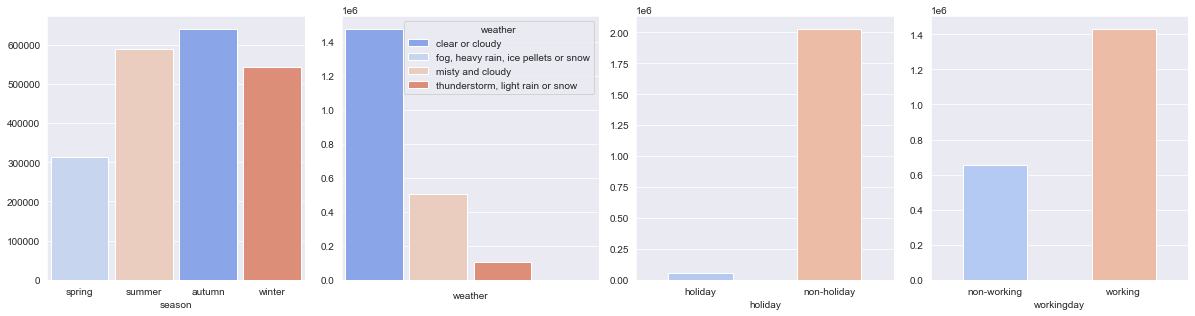

## Numerical Attributes

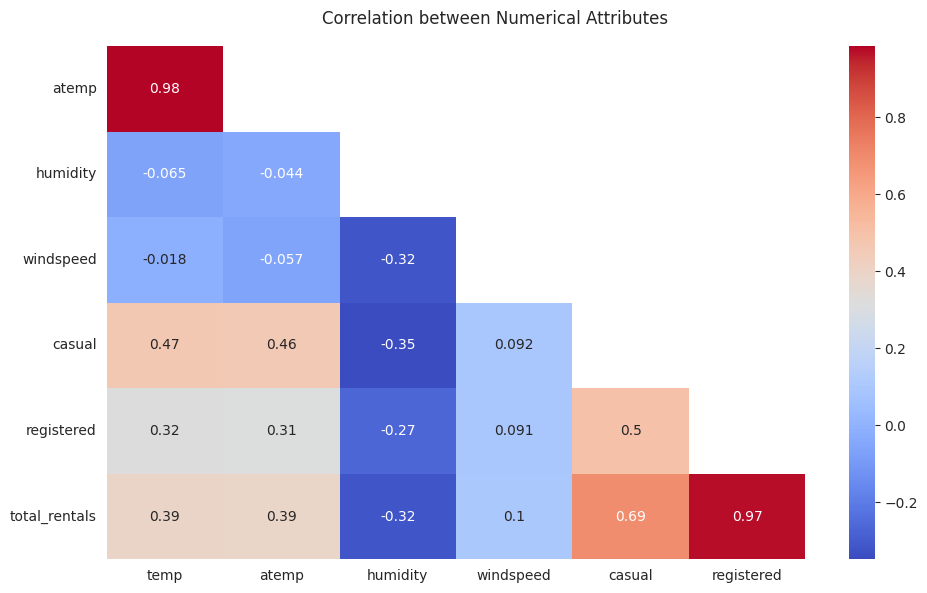

In [29]:
corr = yulu.select_dtypes(include=np.number).corr()
corr = corr.iloc[1:, :-1]
columns = corr.columns
for idx, col in enumerate(columns):
  for idy in range(idx+1, len(columns)):
    corr.iloc[idx, idy] = np.nan

sns.set_style("white")
fig = plt.figure(figsize=(10, 6)) # Change this line to pass figsize as a tuple
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.suptitle('Correlation between Numerical Attributes')
plt.tight_layout()
plt.show()

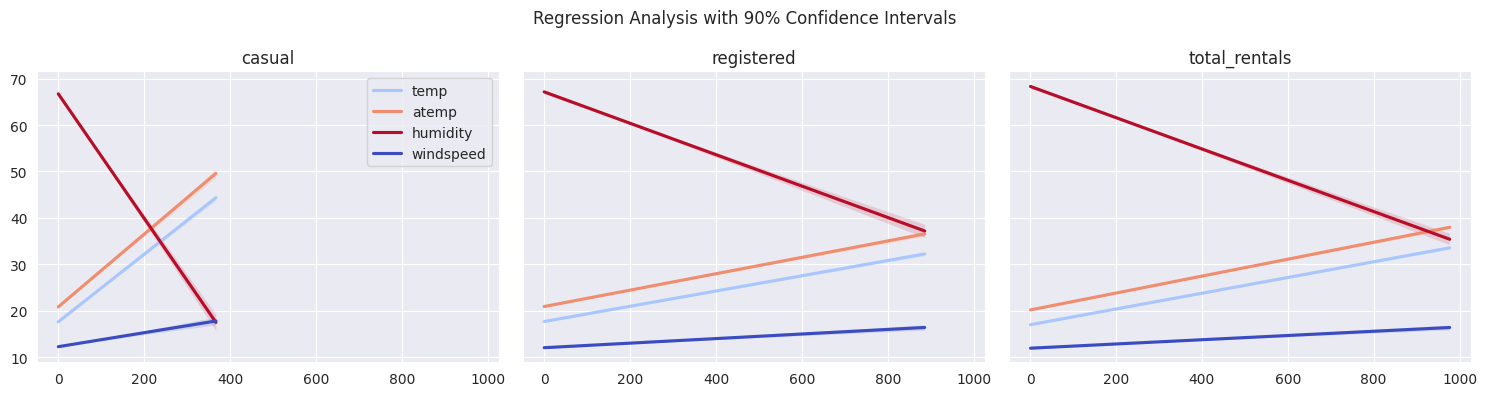

In [30]:
sns.set_style("darkgrid")

# Plotting regplot for each variable without scatter points
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, sharex=True)
column = ['casual', 'registered', 'total_rentals']
rows = ['temp', 'atemp', 'humidity', 'windspeed']
colors = ['#a9c6fd', '#f18d6f', '#b70d28', '#3b4cc0']
plot = None

for idx, ax in enumerate(axes.flat):
    for idy, row in enumerate(rows):
        kwargs = dict(
            color = colors[idy], ci = 90, ax = ax,
            scatter_kws={'alpha':0.0}, scatter=False
        )
        plot = sns.regplot(x=column[idx], y=row, data=yulu, label=row, **kwargs)
    ax.set(xlabel='', ylabel='', title=column[idx])


# Customize the plot
plt.suptitle('Regression Analysis with 90% Confidence Intervals')
handles, labels = plot.get_legend_handles_labels()
axes[0].legend(handles, labels)

plt.tight_layout()
plt.show()

The correlation between rentals and wind speed is positive but weak,
  - In the regression plot, the line did not cross $20\ mph$ wind speed. To back this up with data, $85\%$ of the rentals have been made when wind speed is $\le 20\ mph$.
  - Therefore, the number of rentals increases as wind speed increases up to a threshold. Beyond this, the risk to safety and inconvenience also increases with higher wind speed.

---

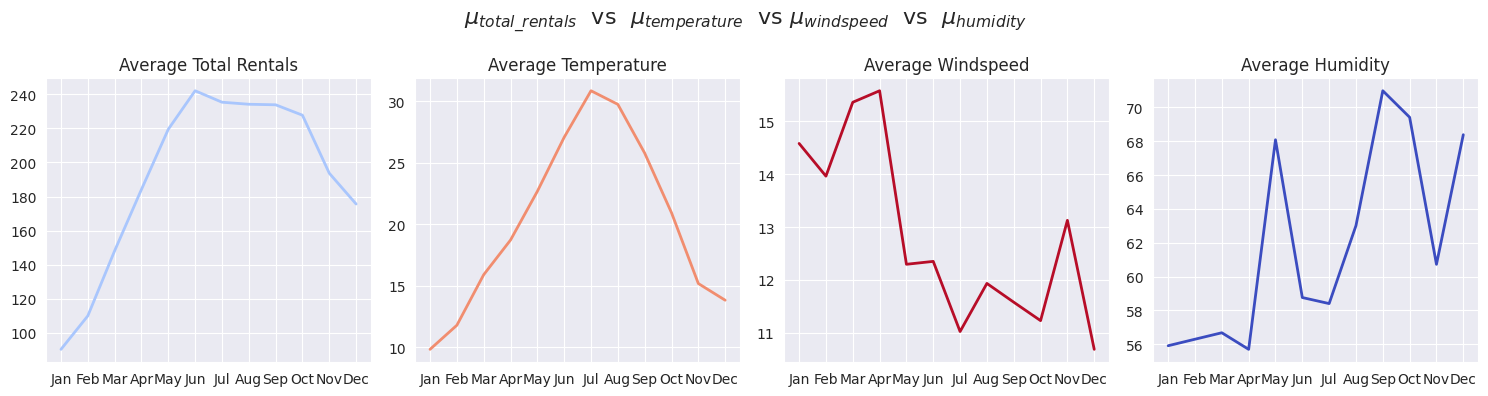

In [31]:
yulu['month'] = yulu.datetime.dt.month_name().str.slice(0, 3).values

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
columns = ['total_rentals', 'temp', 'windspeed', 'humidity']
colors = ['#a9c6fd', '#f18d6f', '#b70d28', '#3b4cc0']
labbels = ['Average Total Rentals', 'Average Temperature', 'Average Windspeed', 'Average Humidity']

for idx, col in enumerate(columns):
    sns.lineplot(yulu.groupby('month')[col].mean()[month_abbr[1:]], lw=2, ax=ax[idx], color=colors[idx])
    ax[idx].set(xlabel='', ylabel='', title=labbels[idx])

plt.suptitle(
    r'$\mu_{total\_rentals}\ \mathsf{\ vs\ }\ \mu_{temperature}\ \mathsf{\ vs\ } \mu_{windspeed}\ \mathsf{\ vs\ }\ \mu_{humidity}$',
    fontsize=16
)
plt.tight_layout()
plt.show()

$$
    \sim \left( \mu_{\text{total\_rentals}} \propto \mu_{\text{temperature}} \propto \frac{1}{\mu_{\text{windspeed}}}\  \rlap{\rule[0.5ex]{1.3em}{0.2pt}} \propto \mu_{\text{total\_rentals}} \right )
$$



In the lineplot we can see that average $total\_rentals$ is directly proportional to average $temperature$, somewhat inversly proportional to average $windspeed$ and not proportional to average $humidity$.

## Time Series Attributes

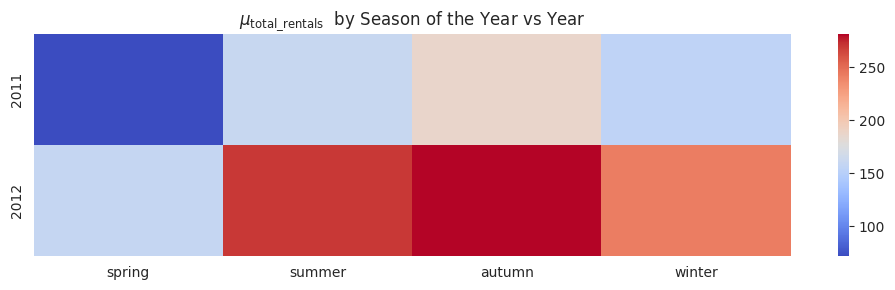

In [32]:
yulu['year'] = yulu.datetime.dt.year.values

# Pivot table
pivot_table = yulu.pivot_table(
    observed=False,
    values='total_rentals',
    index='year',
    columns='season',
    aggfunc='mean'
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(pivot_table[['spring', 'summer', 'autumn', 'winter']], cmap='coolwarm', ax=ax)
ax.set(
    xlabel='', ylabel='', title=r'$\mu_{\mathsf{total\_rentals}}\ \mathsf{\  by\ Season\ of\ the\ Year\ vs\ Year}$'
)

plt.tight_layout()
plt.show()

The above heatmap highlights a very important aspect of the adoption of rental bikes by the general population, as we can see the increase in rentals from $2011$ to $2012$.

---

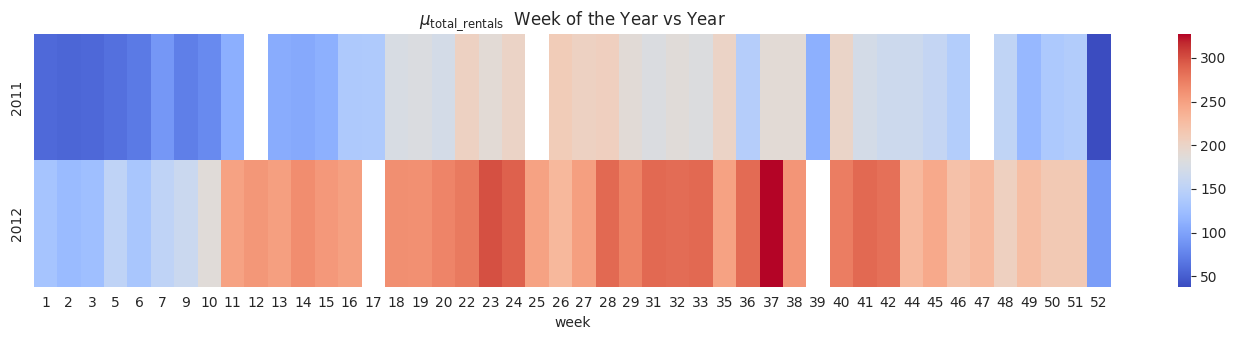

In [33]:
sns.set_style('white')
yulu['week'] = yulu.datetime.dt.isocalendar().week.values

# Pivot table
pivot_table = yulu.pivot_table(
    values='total_rentals',
    index='week',
    columns='year',
    aggfunc='mean'
).T

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 3.5))
sns.heatmap(pivot_table, cmap='coolwarm', ax=ax)
ax.set(xlabel='week', ylabel='', title=r'$\mu_{\mathsf{total\_rentals}}\ \mathsf{\  Week\ of\ the\ Year\ vs\ Year}$')

plt.tight_layout()
plt.show()

### Observations $-$
- The above graph further solidifies our previous understanding of the adoption of rental bikes and how spring is the most affected season (with the least rented bikes) since the inception.
- The not so obvious information is that there are $6$ weeks missing (no rentals whatsoever) from the total $52$ weeks and $5$ weeks with either no rentals in $2011$ or $2012$. For example, the $4^{th}$ week, $8^{th}$ week, and so on.

---

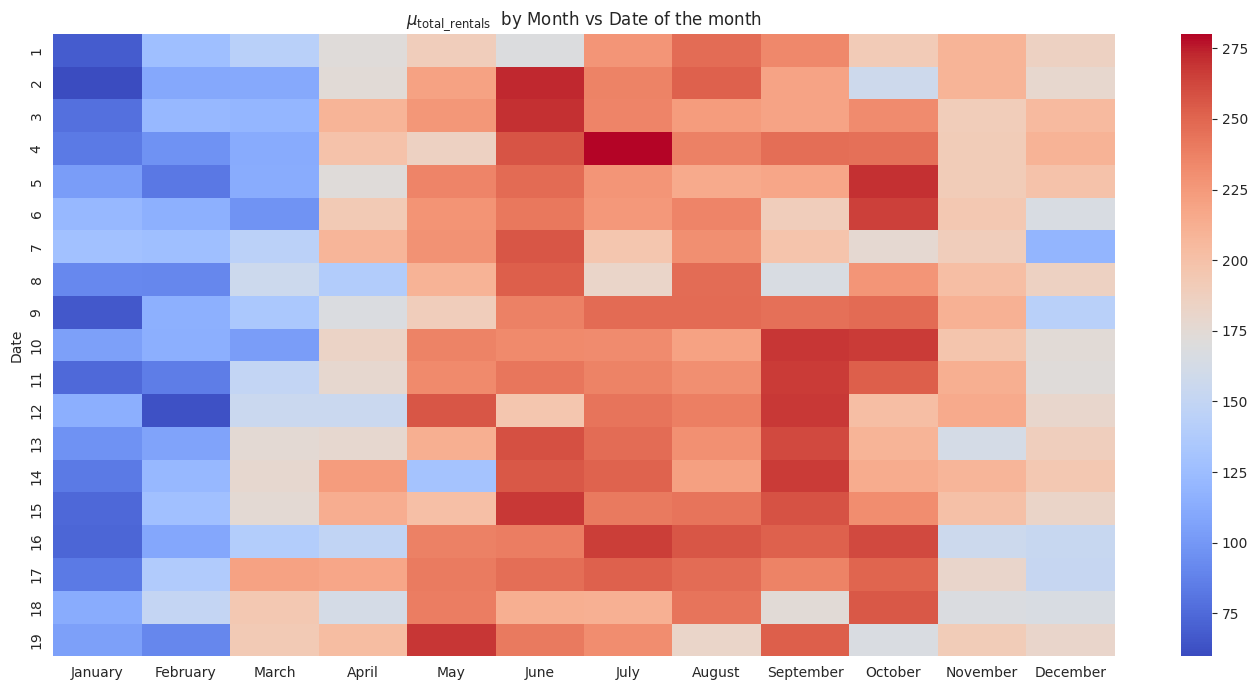

In [34]:
yulu['month'] = yulu.datetime.dt.month_name().values
yulu['date'] = yulu.datetime.dt.day.values

# Pivot table
pivot_table = yulu.pivot_table(
    values='total_rentals',
    index='date',
    columns='month',
    aggfunc='mean'
)

# Month order
pivot_table = pivot_table[
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
]

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(pivot_table, cmap='coolwarm', ax=ax)
ax.set(xlabel='', ylabel='Date', title=r'$\mu_{\mathsf{total\_rentals}}\ \mathsf{\ by\ Month\ vs\ Date\ of\ the\ month}$')

plt.tight_layout()
plt.show()

### Observations $-$
- We can clearly see that the first quarter is slow in terms of average rentals. This can be due to multiple environmental factors, such as wind speed—only $23\%$ of the rentals have been made in spring when the wind speed is more than $20\ mph$ (as we have seen in the trend analysis).
- There can be other contributing environmental factors like temprature (as low as $0.82\ °C$ ) and varying humidity (ranging from $0$ to $100$ $g/m^3$).

Also it is worth noting that there are no rentals from $20^{th}$ onwards for every month.

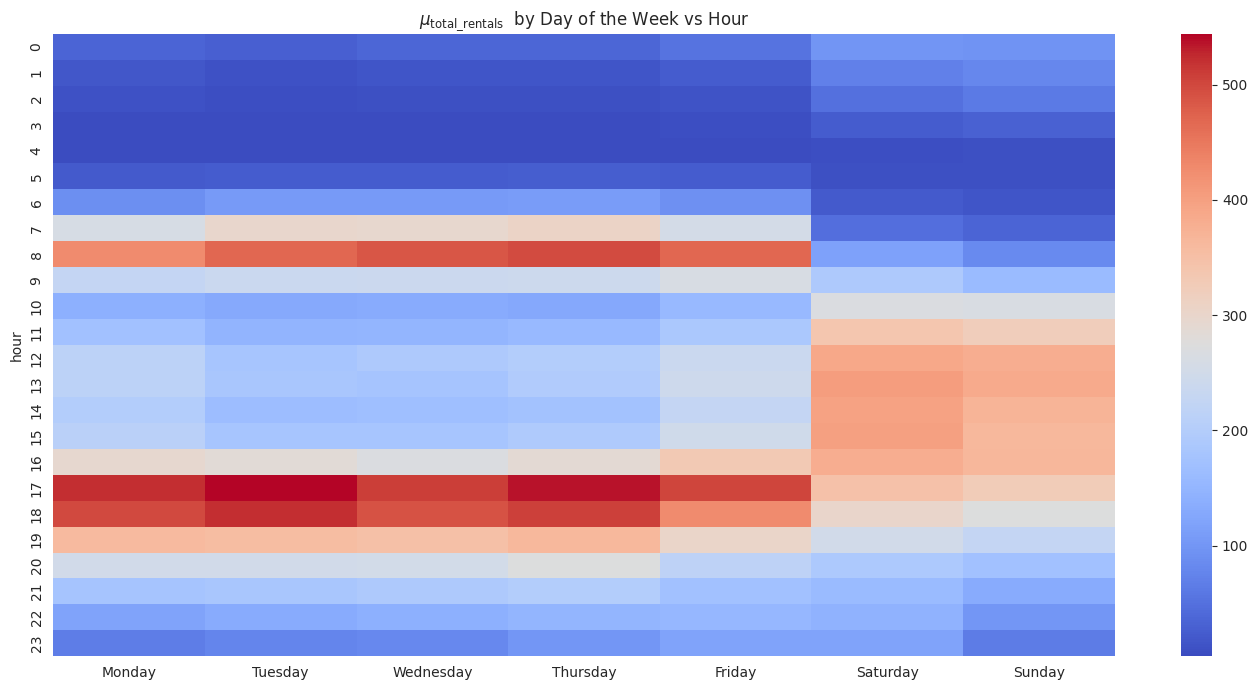

In [35]:
yulu['hour'] = yulu.datetime.dt.hour.values
yulu['day'] = yulu.datetime.dt.day_name().values

pivot_tb = yulu.pivot_table(values='total_rentals', index='hour', columns='day', aggfunc='mean')
pivot_tb = pivot_tb[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

fig = plt.figure(figsize=(14, 7))
sns.heatmap(pivot_tb, cmap='coolwarm')
plt.title(r'$\mu_{\mathsf{total\_rentals}}\ \mathsf{\ by\ Day\ of\ the\ Week\ vs\ Hour}$')
plt.xlabel('')
plt.tight_layout()
plt.show()

# 5. Profiling & Advance Statistics

## In this section —

We'll try to answer the following questions with a certain level of confidence using the hypothesis testing framework:
1. Does a working day have an effect on the number of electric cycles rented?
2. Does a season have an effect on the number of electric cycles rented?
3. Does a weather condition have an effect on the number of electric cycles rented?
4. Is weather dependent on the season?

### For the preceding questions, the following approach will be used:

  1. Groups Data Distribution
  2. Demonstrating Central Limit Theorem
  3. Testing Hypothesis
  4. Calculating & Comparing CI

In [36]:
# Function to calculate confidence interval
def calc_conf_interval(data, confidence):
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2.0, len(data) - 1)
    return round(mean - h, 2), round(mean + h, 2)


# Confidence levels
confidence_levels = [0.90, 0.95, 0.99]

# Significance level
alpha = 0.05

# Categorical Groups
working_groups = ("working", "non-working")
season_groups = ('spring', 'summer', 'autumn', 'winter')
weather_groups = sorted(yulu.weather.unique())

weather_groups.remove("fog, heavy rain, ice pellets or snow")

## Does a **working day** have an effect on the number of electric cycles rented?

### 1. Groups Data Distribution

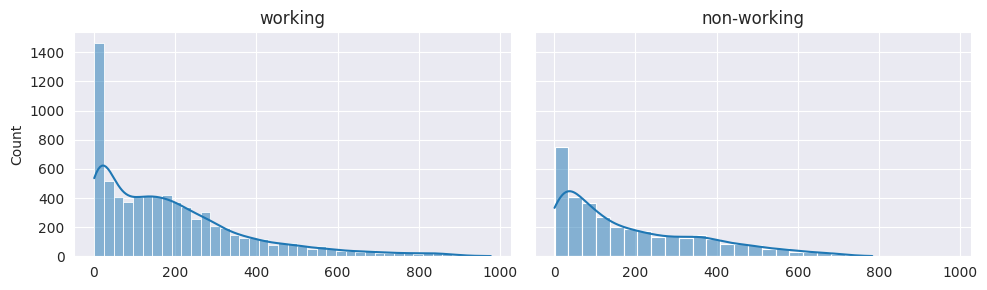

In [37]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)
for idx, ax in enumerate(axs.flat):
  sns.histplot(yulu[yulu.workingday == working_groups[idx]].total_rentals, kde=True, ax=ax)
  ax.set(xlabel='', title=working_groups[idx])

plt.tight_layout()
plt.show()

### 2. Demonstrating Central Limit Theorem

![workingdays_clt_profiling.png](attachment:30ff4af5-e9b5-4825-b4be-95bb485fd7da.png)

### 3. Testing Hypothesis

- **Null Hypothesis ($H_0$) $-$** The average rentals are same for working and non-working days, i.e., $μ_{\text{working}} = μ_{\text{non-working}}$
- **Alternative Hypothesis ($H_a$) $-$** The average rentals are not same for working and non-working days, i.e., $μ_{\text{working}} \ne μ_{\text{non-working}}$

Significance Level ($α$) $-$ $0.05$

In [38]:
# Two-tailed test

working = yulu[yulu.workingday == "working"]
non_working = yulu[yulu.workingday == "non-working"]

t_stat, p_value = stats.ttest_ind(
    working.total_rentals, non_working.total_rentals, alternative="two-sided"
)

# Output the results
print("T-statistic:", t_stat.round(2))
print("P-value:", p_value)

if p_value < alpha:
    print("The average rentals are not same for working and non-working days.")
else:
    print("The average rentals are same for working and non-working days.")

T-statistic: 1.21
P-value: 0.22644804226361348
The average rentals are same for working and non-working days.


### 4. Calculating & Comparing CI

In [39]:
for group in working_groups:
    print(f"Confidence Intervals for {group.capitalize()}:")
    for conf in confidence_levels:
        ci = calc_conf_interval(yulu[yulu.workingday == group].total_rentals, conf)
        print(f"{int(conf*100)}% Confidence Interval: {ci}")
    print()

Confidence Intervals for Working:
90% Confidence Interval: (np.float64(189.49), np.float64(196.54))
95% Confidence Interval: (np.float64(188.81), np.float64(197.21))
99% Confidence Interval: (np.float64(187.49), np.float64(198.53))

Confidence Intervals for Non-working:
90% Confidence Interval: (np.float64(183.66), np.float64(193.36))
95% Confidence Interval: (np.float64(182.73), np.float64(194.29))
99% Confidence Interval: (np.float64(180.91), np.float64(196.1))



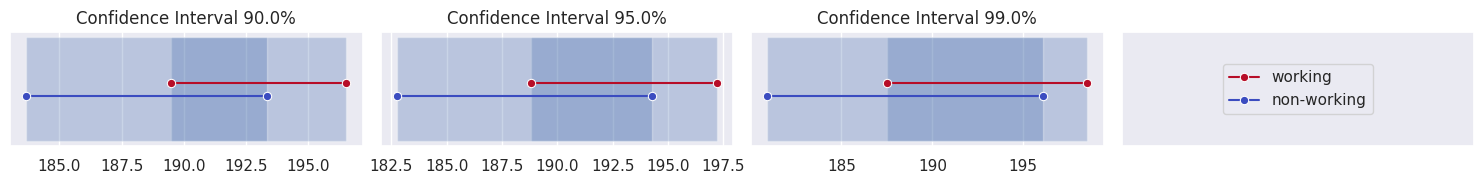

## Does a **season** have an effect on the number of electric cycles rented?

### 1. Groups Data Distribution

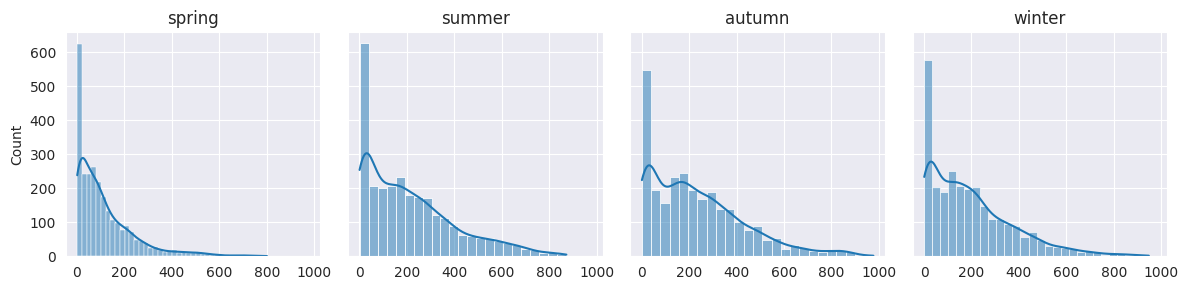

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, sharex=True)
for idx, ax in enumerate(axs.flat):
  sns.histplot(yulu[yulu.season == season_groups[idx]].total_rentals, kde=True, ax=ax)
  ax.set(xlabel='', title=season_groups[idx])

plt.tight_layout()
plt.show()

### 2. Demonstrating Central Limit Theorem

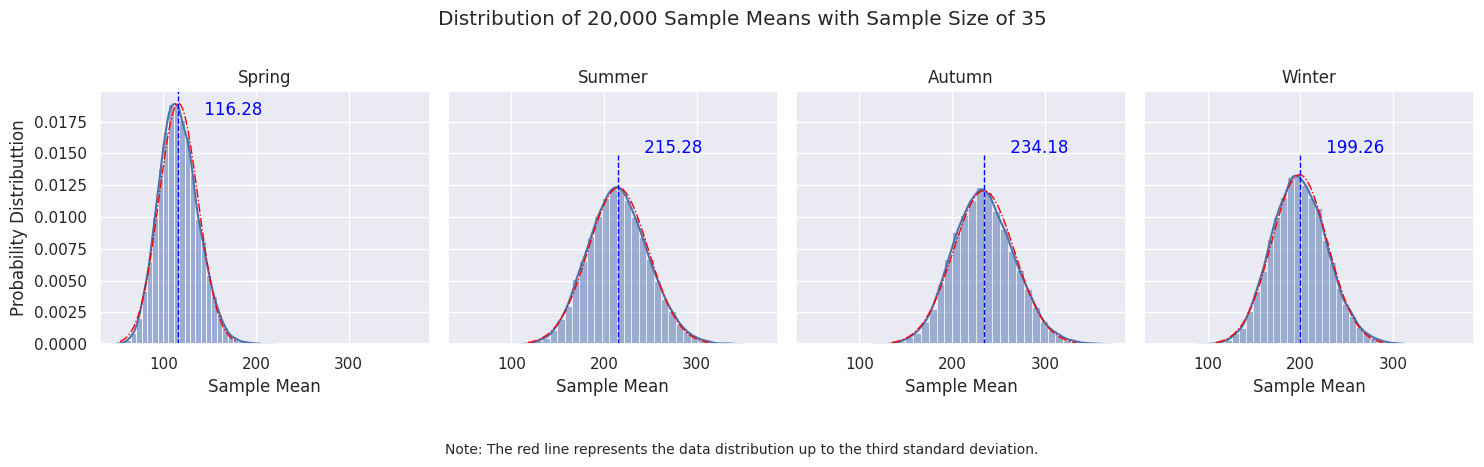

### 3. Testing Hypothesis

- **Null Hypothesis ($H_0$) $-$** The average rentals do not depend on the season.
- **Alternative Hypothesis ($H_a$) $-$** The average rentals depend on the season (at least one seasonal mean is different).

Significance Level ($α$) $-$ $0.05$

Since there are more than two groups (four seasons) we cannot apply $\ T-test$.

We'll test for ANOVA and its pre-requisite are,
  1. Groups (seasons) of the category should be normally distributed. (But as we seen in the data distribution sub-section groups are exponentilly distributed.)
  2. Groups should be independent. (Since, season column contains only one value for every row, we can say that groups are independent.)
  3. Levene's test. (homogeneity / equality of variances)

In [41]:
# ANOVA Hypothesis Testing

# 1. Normality
for season in season_groups:
    season_data = yulu[yulu.season == season].total_rentals
    stat, p_value = stats.shapiro(season_data)
    if p_value < alpha:
        print(f"{season.capitalize()} data is normally distributed. p-value: {p_value}")
    else:
        print(f"{season.capitalize()} data is not normally distributed. p-value: {p_value}")

Spring data is normally distributed. p-value: 8.749584618867662e-49
Summer data is normally distributed. p-value: 6.039374406270491e-39
Autumn data is normally distributed. p-value: 1.043680518918597e-36
Winter data is normally distributed. p-value: 1.1299244409282836e-39


### Box-Cox Transformation

In [42]:
box_cox = yulu[["season", "total_rentals"]].copy()
box_cox["box_coxed_total_rentals"], fitted_lambda = stats.boxcox(yulu.total_rentals)
print(f"Optimal λ for Box-Cox transformation: {fitted_lambda}")

Optimal λ for Box-Cox transformation: 0.3156702511500272


In [43]:
# Check Normality for transformed data
for season in season_groups:
    season_data = box_cox[box_cox.season == season].box_coxed_total_rentals
    stat, p_value = stats.shapiro(season_data)
    if p_value < alpha:
        print(f"{season.capitalize()} Box-Cox transformed data is not normally distributed. p-value: {p_value}")
    else:
        print(f"{season.capitalize()} Box-Cox transformed data is normally distributed. p-value: {p_value}")

Spring Box-Cox transformed data is not normally distributed. p-value: 9.903301028237622e-17
Summer Box-Cox transformed data is not normally distributed. p-value: 3.8640779693305347e-23
Autumn Box-Cox transformed data is not normally distributed. p-value: 7.944779244444369e-25
Winter Box-Cox transformed data is not normally distributed. p-value: 4.0446110891423347e-22


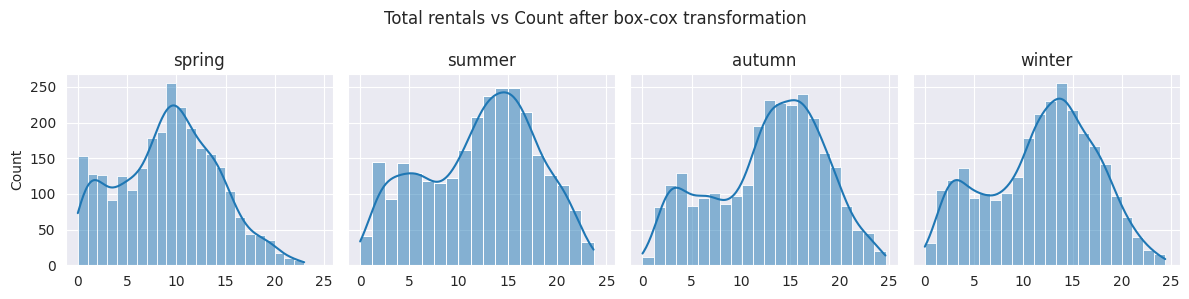

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, sharex=True)
for idx, ax in enumerate(axs.flat):
  sns.histplot(box_cox[box_cox.season == season_groups[idx]].box_coxed_total_rentals, kde=True, ax=ax)
  ax.set(xlabel='', title=season_groups[idx])

plt.suptitle('Total rentals vs Count after box-cox transformation')
plt.tight_layout()
plt.show()

Since the total_rental data is not normally distributed for different seasons and cannot be transformed to normality using $Box-Cox$, we can not apply ANOVA.

We'll apply,
- Welch ANOVA (parametric test, less sensitive to violations of normality and homogeneity of variances)
- Kruskal-Wallis (Non-parametric test)

and compare the results.

### Welch ANOVA

In [45]:
# Perform Welch's ANOVA
welch_anova = pg.welch_anova(dv="total_rentals", between="season", data=yulu)
welch_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,season,3,5945.553571,335.08888,4.844999e-201,0.061317


- F-statistic value obtained from the Welch's ANOVA test indicates the ratio of the variance between the group means to the variance within the groups.
<center>$F = \frac{\text{Weighted variance between groups}} {\text{Variance within groups}}$</center>

  - A higher F value ($335.089$) suggests a more significant difference between the group means.
- The p-value ($4.8449^{-201}$) is extremely low. This indicates that there are statistically significant differences between the means of the seasons.

In [46]:
p_value = welch_anova["p-unc"].iloc[0]
if p_value < alpha:
    print("The average rentals depend on the season (at least one seasonal mean is different).")
else:
    print("The average rentals do not depend on the season.")

The average rentals depend on the season (at least one seasonal mean is different).


### Post-Hoc Analysis

> Given that Welch's ANOVA results show a highly significant difference in rental means between seasons, **with an extremely low p-value**, we'll identify if one pair or more than one pair of groups have significant differences in their means with post-hoc analysis using $Games-Howell$ test.


In [47]:
# Perform Games-Howell post-hoc test
posthoc = pg.pairwise_gameshowell(dv="total_rentals", between="season", data=yulu)
posthoc.style.hide(axis='index')

A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
autumn,spring,234.417124,116.343261,118.073863,4.479358,26.359548,4640.865715,0.000000,0.713451
autumn,summer,234.417124,215.251372,19.165752,5.264171,3.640792,5460.186519,0.001563,0.098476
autumn,winter,234.417124,198.988296,35.428829,5.075597,6.980228,5406.191978,0.000000,0.188788
spring,summer,116.343261,215.251372,-98.908111,4.396852,-22.495212,4711.743230,0.000000,-0.608974
spring,winter,116.343261,198.988296,-82.645034,4.169232,-19.822604,4917.869966,0.000000,-0.536855
summer,winter,215.251372,198.988296,16.263077,5.002933,3.250708,5431.881250,0.006364,0.087918


### Kruskal-Wallis

In [48]:
# Perform Kruskal-Wallis Test
kruskal_result = stats.kruskal(
    *[yulu[yulu.season == season].total_rentals for season in season_groups]
)
print(f"H-statistics: {kruskal_result[0]}", end="\n")
print(f"P-value: {kruskal_result[1]}")

H-statistics: 699.6668548181988
P-value: 2.479008372608633e-151


In [49]:
p_value = kruskal_result[1]
if p_value < alpha:
    print("The average rentals depend on the season (at least one seasonal mean is different).")
else:
    print("The average rentals do not depend on the season.")

The average rentals depend on the season (at least one seasonal mean is different).


### Post-Hoc Analysis

In [50]:
rename = {1: "winter", 2: "spring", 3: "summer", 4: "autumn"}
min_sample_size = min(
    [len(yulu[yulu.season == season].total_rentals) for season in season_groups]
)

# Perform Dunn's post-hoc test
# Since we are down-sampling,
# we are going to do it 1000 for robustness and stability.

result = []
for _ in range(1000):
    posthoc_results = posthoc_dunn(
        [
            yulu[yulu.season == season].total_rentals.sample(min_sample_size)
            for season in season_groups
        ]
    )
    result.append(posthoc_results)

mean_results = pd.concat(result).groupby(level=0).mean()
mean_results.rename(columns=rename, index=rename)

,winter,spring,summer,autumn
winter,1.000000e+00,2.524557e-90,3.334125e-130,1.438776e-72
spring,2.524557e-90,1.000000e+00,4.198025e-05,3.319441e-02
summer,3.334125e-130,4.198025e-05,1.000000e+00,4.872805e-10
autumn,1.438776e-72,3.319441e-02,4.872805e-10,1.000000e+00


#### Summary $-$
- Both Welch's ANOVA and Kruskal-Wallis test concluded that average total rentals depend on the seasons.
- No two seasons are independent with respect to average total rentals (all of them are different from each other).

### 4. Calculating & Comparing CI

In [51]:
for group in season_groups:
    print(f"Confidence Intervals for {group.capitalize()}:")
    for conf in confidence_levels:
        ci = calc_conf_interval(yulu[yulu.season == group].total_rentals, conf)
        print(f"{int(conf*100)}% Confidence Interval: {ci}")
    print()

Confidence Intervals for Spring:
90% Confidence Interval: (np.float64(112.37), np.float64(120.32))
95% Confidence Interval: (np.float64(111.6), np.float64(121.08))
99% Confidence Interval: (np.float64(110.11), np.float64(122.57))

Confidence Intervals for Summer:
90% Confidence Interval: (np.float64(209.21), np.float64(221.29))
95% Confidence Interval: (np.float64(208.05), np.float64(222.45))
99% Confidence Interval: (np.float64(205.78), np.float64(224.72))

Confidence Intervals for Autumn:
90% Confidence Interval: (np.float64(228.21), np.float64(240.62))
95% Confidence Interval: (np.float64(227.02), np.float64(241.81))
99% Confidence Interval: (np.float64(224.7), np.float64(244.14))

Confidence Intervals for Winter:
90% Confidence Interval: (np.float64(193.4), np.float64(204.58))
95% Confidence Interval: (np.float64(192.33), np.float64(205.65))
99% Confidence Interval: (np.float64(190.23), np.float64(207.74))



![seasons_ci_profiling.png](attachment:7485cb5a-f6be-40b8-b55f-27c82b76af45.png)

## Does a weather condition have an effect on the number of electric cycles rented?

### 1. Groups Data Distribution

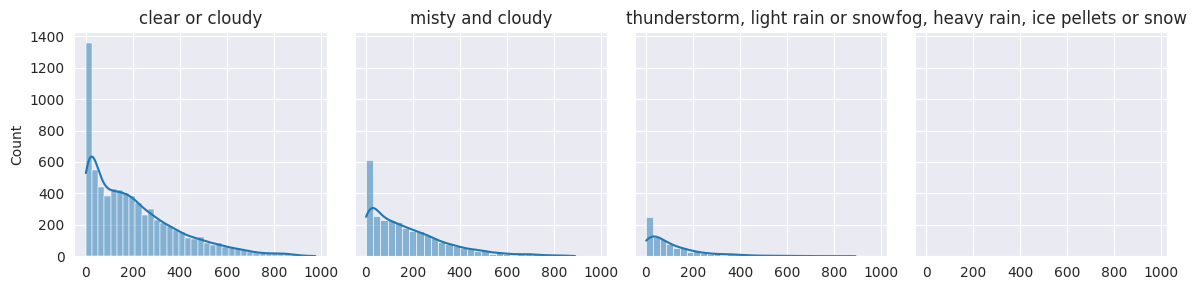

In [52]:
weather = yulu.weather.unique()
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, sharex=True)
for idx, ax in enumerate(axs.flat):
  sns.histplot(yulu[yulu.weather == weather[idx]].total_rentals, kde=True, ax=ax)
  ax.set(xlabel='', title=weather[idx])

plt.tight_layout()
plt.show()

In [53]:
yulu[yulu.weather == "fog, heavy rain, ice pellets or snow"].style.hide(axis='index')

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,month,year,week,date,hour,day
2012-01-09 18:00:00,spring,non-holiday,working,"fog, heavy rain, ice pellets or snow",8.200000,11.365000,86,6.003200,6,158,164,January,2012,2,9,18,Monday


As we can see, there is only $one$ record for the "fog, heavy rain, ice pellets, or snow" weather group.

### 2. Demonstrating Central Limit Theorem

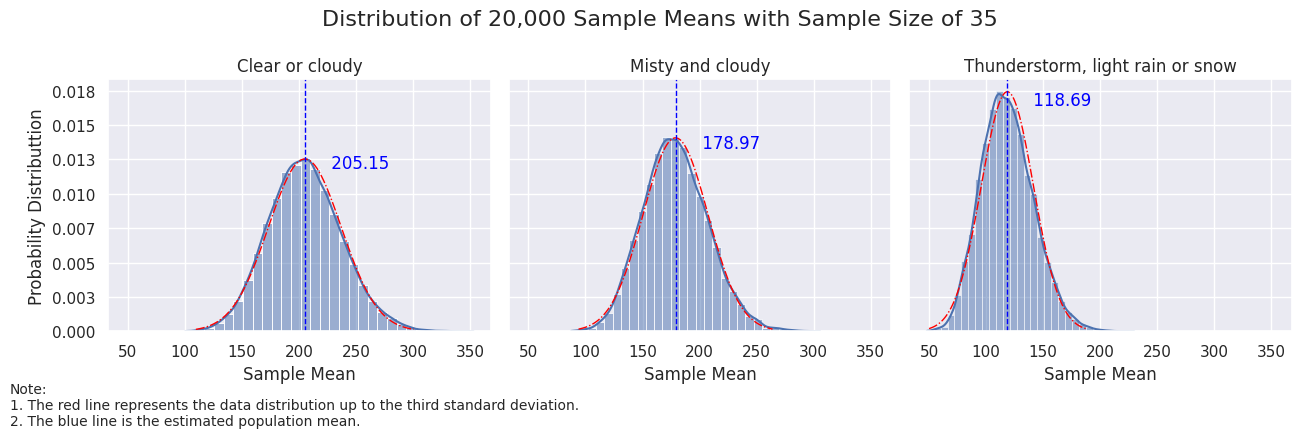

### 3. Testing Hypothesis

Since there are more than two groups (four weathers) we cannot apply $\ T-test$.

We'll test for ANOVA and its pre-requisite are,
  1. Groups (weathers) of the category should be normally distributed.
  2. Groups should be independent.
  3. Levene's test. (homogeneity / equality of variances)

Since there is only $one$ record in "fog, heavy rain, ice pellets or snow" weather group, we cannot apply ANOVA if we consider all the groups, therefore we'll exclude "fog, heavy rain, ice pellets or snow" weather group.

- **Null Hypothesis ($H_0$) $-$** The average rentals do not depend on the weather.
- **Alternative Hypothesis ($H_a$) $-$** The average rentals depend on the weather (at least one  weather mean is different).

Significance Level ($α$) $-$ $0.05$

In [54]:
# 1. Normality
for weather in weather_groups:
    weather_data = yulu[yulu.weather == weather].total_rentals
    stat, p = stats.kstest(weather_data, "norm")
    if p < alpha:
        print(f"{weather.capitalize()} data is normally distributed. p-value: {p}")
    else:
        print(f"{weather.capitalize()} data is not normally distributed. p-value: {p}")

Clear or cloudy data is normally distributed. p-value: 0.0
Misty and cloudy data is normally distributed. p-value: 0.0
Thunderstorm, light rain or snow data is normally distributed. p-value: 0.0


In [55]:
# 2. Since, weather column contains only one value for every row, we can say that groups are independent.

# 3. Levene's test. (homogeneity / equality of variances)
# Null Hypothesis: Levene's test assumes that the variances of the groups are equal (homoscedasticity).
# Alternative Hypothesis: The variances of the groups are not equal (heteroscedasticity).

levene_stat, levene_p_value = stats.levene(
    *[yulu[yulu.weather == weather].total_rentals for weather in weather_groups]
)
print("\nLevene's Test for Homogeneity of Variances:")
print("Statistic:", levene_stat)
print("P-value:", p_value)

if p_value < alpha:
    print("The variances of the groups are not equal (heteroscedasticity).")
else:
    print("Levene's test assumes that the variances of the groups are equal (homoscedasticity).")


Levene's Test for Homogeneity of Variances:
Statistic: 81.67574924435011
P-value: 2.479008372608633e-151
The variances of the groups are not equal (heteroscedasticity).


> We cannot apply ANOVA since the Levene's test fialed, but the weather groups are normally distributed, so we can leverage that property to get more reliable result instead of using any non-parametric test. Welch's ANOVA test is designed to handle situations with unequal variances.

In [56]:
# Filter data for fog, heavy rain, ice pellets or snow group
filtered = yulu[yulu.weather != "fog, heavy rain, ice pellets or snow"]
welch_anova = pg.welch_anova(dv="total_rentals", between="weather", data=filtered)
welch_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,weather,2,2449.219851,140.900662,1.200220e-58,0.017743


- F-statistic value obtained from the Welch's ANOVA test indicates the ratio of the variance between the group means to the variance within the groups.
<center>$F = \frac{\text{Weighted variance between groups}} {\text{Variance within groups}}$</center>

  - A higher F value ($140.9$) suggests a more significant difference between the group means.
- The p-value ($1.2^{-58}$) is extremely low. This indicates that there are statistically significant differences between the means of the weather groups.

In [57]:
p_value = welch_anova["p-unc"].iloc[0]
if p_value < alpha:
    print("The average rentals depend on the weather (at least one weather mean is different).")
else:
    print("The average rentals do not depend on the weather.")

The average rentals depend on the weather (at least one weather mean is different).


### Post-Hoc Analysis

In [58]:
# Perform pairwise comparisons
pg.pairwise_gameshowell(dv="total_rentals", between="weather", data=filtered).style.hide(axis='index')

A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
clear or cloudy,misty and cloudy,205.236791,178.955540,26.281251,3.861968,6.805145,5752.262973,0.000000,0.143889
clear or cloudy,"thunderstorm, light rain or snow",205.236791,118.846333,86.390458,5.222008,16.543532,1269.143920,0.000000,0.471184
misty and cloudy,"thunderstorm, light rain or snow",178.955540,118.846333,60.109207,5.688558,10.566687,1694.740304,0.000000,0.371125


All comparisons show highly significant differences (very low p-values), indicating that bike rentals significantly differ between the weather conditions.

### 4. Calculating & Comparing CI

In [59]:
for group in weather_groups:
    print(f"Confidence Intervals for {group.capitalize()}:")
    for conf in confidence_levels:
        ci = calc_conf_interval(yulu[yulu.weather == group].total_rentals, conf)
        print(f"{int(conf*100)}% Confidence Interval: {ci}")
    print()

Confidence Intervals for Clear or cloudy:
90% Confidence Interval: (np.float64(201.59), np.float64(208.88))
95% Confidence Interval: (np.float64(200.89), np.float64(209.58))
99% Confidence Interval: (np.float64(199.53), np.float64(210.95))

Confidence Intervals for Misty and cloudy:
90% Confidence Interval: (np.float64(173.75), np.float64(184.16))
95% Confidence Interval: (np.float64(172.75), np.float64(185.16))
99% Confidence Interval: (np.float64(170.8), np.float64(187.11))

Confidence Intervals for Thunderstorm, light rain or snow:
90% Confidence Interval: (np.float64(111.06), np.float64(126.63))
95% Confidence Interval: (np.float64(109.57), np.float64(128.13))
99% Confidence Interval: (np.float64(106.64), np.float64(131.05))



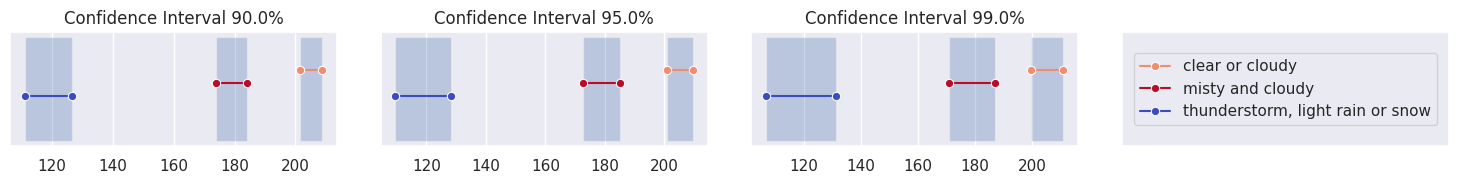

## Is weather dependent on the season?

Since we have already seen the data distribution of different groups in both $season$ and $weather$ categories in preceeding two questions, in this question I'll directly tackel the question, *Is weather dependent on the seasons?*

Since both the columns are categorical and we have to test for association, we'll use $Chi-squared$ test of Independence.

- **Null Hypothesis ($H_0$) $-$** Weather conditions are independent of the seasons.
- **Alternative Hypothesis ($H_a$) $-$** Weather conditions depend on the season.

Significance Level ($α$) $-$ $0.05$

In [60]:
# Creating contingency table
contingency_table = pd.crosstab(yulu.season, yulu.weather)

# Perform Chi-Square Test of Independence
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

if p_value < alpha:
  print("Weather conditions depend on the season.")
else:
  print("Weather conditions are independent of the seasons.")

Weather conditions depend on the season.


# 6. Time Series Statistics

## In this section $-$
1. Data cleaning and kNN imputation.
   - Data is missig at two levels
     * Hourly data for the available dates.
     * Data from $20^{th}$ to end of the month.
     * We'll add the missing hourly data and impute it with kNN.
2. Test for the presence of a unit root (i.e. non-stationary) in a time series.
   - Since after data cleaning and imputation, there is \[still\] one structural break therefore, we'll use Zivot-Andrews Test to test if series is stationary.
   - If series is non-stationary, we'll apply differencing to make it stationary, since VAR model assumes that.
3. Test if one time series can predict another.
   - Vector Autoregression (VAR)

## Data cleaning and kNN Imputation

In [61]:
# Datetime as index.
yulu = pd.read_csv(path + '/yulu_bike_sharing_dataset.csv')
datetime = yulu.datetime.map(pd.to_datetime)
yulu.index = datetime
yulu.drop(columns=[
    'datetime', 'season', 'holiday', 'workingday', 'weather', 'atemp', 'casual', 'registered'
], inplace=True)
yulu.rename(columns={"count": "total_rentals"}, inplace=True)

In [62]:
# Central Tendency and Std Performance Metrics
before_imputation = dict()
for col in yulu.columns:
  before_imputation[col]=(yulu[col].mean(), yulu[col].median(), yulu[col].mode()[0], yulu[col].std())

In [63]:
unique_dates = datetime.dt.date.unique()
all_hours = pd.date_range(start=unique_dates.min(), end=unique_dates.max() + timedelta(days=1), freq='H')
all_hours = all_hours[all_hours.floor('D').map(pd.to_datetime).isin(unique_dates)]
yulu = yulu.reindex(all_hours)
datetime = yulu.index.map(pd.to_datetime)
yulu['total_rentals'] = yulu['total_rentals'].fillna(0)
yulu.reset_index(drop=True, inplace=True)

In [64]:
imputer = KNNImputer(n_neighbors=2, weights='distance')
nan_indices = yulu.index[yulu.isna().any(axis=1)]

for idx in nan_indices:
    # Get the position of the current index
    pos = yulu.index.get_loc(idx)

    # Get the surrounding rows (4 before, 4 after)
    start = max(0, pos - 4)
    end = min(len(yulu), pos + 4 + 1)
    subset = yulu.iloc[start:end]

    # Apply KNN Imputer to the subset
    imputed_subset = pd.DataFrame(imputer.fit_transform(subset), index=subset.index, columns=subset.columns)

    # Update the original DataFrame with imputed values
    yulu.loc[pos] = imputed_subset.loc[pos]

In [65]:
# Central Tendency and Std Performance Metrics
after_imputation = dict()
for col in yulu.columns:
  after_imputation[col]=(yulu[col].mean(), yulu[col].median(), yulu[col].mode()[0], yulu[col].std())

In [66]:
print("Befor and After deviation of mean, median, mode and std -")
for key, val in before_imputation.items():
  print(f"{key} -> {list(zip(val, after_imputation[key]))}")

Befor and After deviation of mean, median, mode and std -
temp -> [(np.float64(20.23085981995223), np.float64(20.17539165255527)), (20.5, 20.5), (np.float64(14.76), np.float64(14.76)), (7.791589843987506, 7.81675453049352)]
humidity -> [(np.float64(61.88645967297446), np.float64(61.93028112560813)), (62.0, 62.0), (np.int64(88), np.float64(88.0)), (19.245033277394786, 19.266946561494947)]
windspeed -> [(np.float64(12.7993954069447), np.float64(12.80558129013911)), (12.998, 12.998), (np.float64(0.0), np.float64(0.0)), (8.16453732683849, 8.161123352334815)]
total_rentals -> [(np.float64(191.57413191254824), np.float64(190.55884502923976)), (145.0, 144.0), (np.int64(5), np.float64(5.0)), (181.14445383028496, 181.19847094441607)]


## Test for the presence of a unit root (i.e. non-stationary) in a time series

In [67]:
# Perform Zivot-Andrews test
temperature_za = ZivotAndrews(yulu['temp'])
print(temperature_za.summary())

        Zivot-Andrews Results        
Test Statistic                 -4.486
P-value                         0.124
Lags                               39
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


- Because the test statistic ($-4.486$) is not less than any of the critical values, and the p-value ($0.124$) is greater than $0.05$, we fail to reject the null hypothesis that the $temperature$ time series contains a unit root with a single structural break.
- In other words, the $temperature$ time series is **non-stationary** even when considering a potential single structural break.

In [68]:
humidity_za = ZivotAndrews(yulu['humidity'])
print(humidity_za.summary())

        Zivot-Andrews Results        
Test Statistic                -11.011
P-value                         0.000
Lags                               39
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


- Because the test statistic ($-11.010$) is far lower than the critical values and the p-value is effectively zero, we reject the null hypothesis that the $humidity$ time series has a unit root with a single structural break.
- In other words, the $humidity$ time series is **stationary** even when considering a potential single structural break.

In [69]:
windspeed_za = ZivotAndrews(yulu['windspeed'])
print(windspeed_za.summary())

        Zivot-Andrews Results        
Test Statistic                -14.160
P-value                         0.000
Lags                               39
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


- Because the test statistic ($-14.161$) is far lower than the critical values and the p-value is effectively zero, we reject the null hypothesis that the the $windspeed$ time series has a unit root with a single structural break.
- In other words, the $windspeed$ time series is **stationary** even when considering a potential single structural break.

In [70]:
total_rentals_za = ZivotAndrews(yulu['total_rentals'])
print(total_rentals_za.summary())

        Zivot-Andrews Results        
Test Statistic                -10.454
P-value                         0.000
Lags                               36
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


- Because the test statistic ($-10.454$) is far lower than the critical values and the p-value is effectively zero, we reject the null hypothesis that the $total\_rentals$ time series has a unit root with a single structural break.
- In other words, the $total\_rentals$ time series is **stationary** even when considering a potential single structural break.

Since only $temperature$ time series is **non-stationary**, we'll apply **differencing** to make it **stationary**.

In [71]:
# Calculate the differenced series
yulu['temp'] = yulu['temp'].diff()

# Drop NaN values that resulted from differencing
yulu = yulu.dropna(subset=['temp'])

In [72]:
# Perform Zivot-Andrews test
diffed_temperature_za = ZivotAndrews(yulu['temp'])
print(diffed_temperature_za.summary())

        Zivot-Andrews Results        
Test Statistic                -22.022
P-value                         0.000
Lags                               39
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


- Because the test statistic ($-22.022$) is far lower than the critical values and the p-value is effectively zero, we reject the null hypothesis that the series has a unit root with a single structural break.

- In other words, the $temperature$ time series is **stationary** even when considering a potential single structural break.

Now that the $temperature$ time series is stationary as well, we can apply the VAR model to statistically determine whether environmental factors have an effect on $total\_rentals$.

## Tests if one time series can predict another

Here, we will test whether $temperature$, $humidity$, and $windspeed$ have \[non-\] causality on $total\_rentals$ as observed in the graphs. For this, we'll use $Vector\ Autoregression$.

**Vector Autoregression** (VAR) is a statistical model used to capture the linear interdependencies among multiple time series.

In [73]:
yulu.index = datetime[1:]

# Fit the VAR model
model = VAR(yulu[['temp', 'humidity', 'windspeed', 'total_rentals']])

# Testing Inter-dependencies on Monthly basis
results = model.fit(maxlags=30 * 24)

### Does $temperature$ causes $total\_rentals$?

In [74]:
temprature_result = results.test_causality(caused='total_rentals', causing='temp')

In [75]:
print(f"{temprature_result.h0}", end="\n\n")
print(f'{temprature_result.summary()}')
print(f"Conclusion: {temprature_result.conclusion} H_0")

H_0: temp does not Granger-cause total_rentals

Granger causality F-test. H_0: temp does not Granger-cause total_rentals. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value      df     
--------------------------------------------------
         1.102          1.089   0.031 (720, 29368)
--------------------------------------------------
Conclusion: reject H_0


- At the $5\%$ significance level, the test statistic ($1.100$) is slightly greater than the critical value ($1.089$), and the p-value ($0.034$) is less than $0.05$. This means that there is significant evidence to reject the null hypothesis.
- In other words, $temperature$ **Granger-causes** $total\ rentals$. This indicates that changes in $temperature$ can provide predictive information for changes in $total\ rentals$.

### Does $humidity$ causes $total\_rentals$?

In [76]:
humidity_result = results.test_causality(caused='total_rentals', causing='humidity')

In [77]:
print(f"{humidity_result.h0}", end="\n\n")
print(f'Test Statistics: {humidity_result.summary()}')
print(f"Conclusion: {humidity_result.conclusion} H_0")

H_0: humidity does not Granger-cause total_rentals

Test Statistics: Granger causality F-test. H_0: humidity does not Granger-cause total_rentals. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value      df     
--------------------------------------------------
         1.019          1.089   0.358 (720, 29368)
--------------------------------------------------
Conclusion: fail to reject H_0


- At the $5\%$ significance level, the test statistic ($1.020$) is less than the critical value ($1.089$), and the p-value ($0.349$) is greater than $0.05$. This means there is no significant evidence to suggest that $humidity$ **Granger-causes** $total\ rentals$.
- In other words, changes in $humidity$ do not provide predictive information for changes in $total\ rentals$ within the context of this model.

### Does $windspeed$ causes $total\_rentals$?

In [78]:
windspeed_result = results.test_causality(caused='total_rentals', causing='windspeed')

In [79]:
print(f"{windspeed_result.h0}", end="\n\n")
print(f'Test Statistics: {windspeed_result.summary()}')
print(f"Conclusion: {windspeed_result.conclusion} H_0")

H_0: windspeed does not Granger-cause total_rentals

Test Statistics: Granger causality F-test. H_0: windspeed does not Granger-cause total_rentals. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value      df     
--------------------------------------------------
        0.9487          1.089   0.832 (720, 29368)
--------------------------------------------------
Conclusion: fail to reject H_0


- At the $5\%$ significance level, the test statistic ($0.9467$) is less than the critical value ($1.089$), and the p-value ($0.842$) is much greater than $0.05$. This means there is no significant evidence to suggest that $windspeed$ **Granger-causes** $total\_rentals$.
- In other words, changes in $windspeed$ do not provide predictive information for changes in $total\_rentals$ within the context of this model.

Our test results indicate that, except for $temperature$, no other environmental factors ($humidity$, $windspeed$) have causality on $total\_rentals$.

# 7. Business Insights

## Results from Exploratory Data Analysis $-$
- Spring has lowest rental since inception, and Autumn has highest number of rentals.
- 70% of the rental has been made when the weather is good, i.e., clear or cloudy.
- Most of the rentals has been made on non-holiday and working days.
- There is weak and moderate weak correlation between rentals and environmental factors, but there are only entries for when a bike is rented, that causes for missing environmental data which could have give further insights on, under what environmental conditions bike are not getting rented.
- From the analysis from time-series attributes we get to know the peak hours $-$ $7$ to $9$ in the $morning$ and $5$ to $7$ in the $evening$ from Monday to Friday and $11$ to $5$ in the afternoon on weekends, which gives us glimps about the renters, office-going people.
- First quater($Q1$) is slow for the business.
- There are no rentals from $20^{th}$ onwards for every month.
- There are $11$ weeks in total with no rentals, whatsoever, with $6$ weeks which are common in both $2011$ and $2012$.

## Results from Hypothesis Testing $-$
- The average rentals depend on the seasons.
- The average rentals depend on the weather conditions.
- Weather conditions depend on the season.
- Temperature has causality on $total\ rentals$

# 8. Recommendation

- As we have seen that environtal factors have effect on rentals, we can collect data even when the bikes are not rented to make more informed decisions.
- Yulu can setup it's distribution points near malls, parks and other weekend spots to increase it's rentals on holidays and non-working days.
- Yulu can also optimize its storage warehouse and distribution logistics to better manage (scale up and scale down) the demands at peak hours.
- Yulu should also investigate if the data is not available for 20th onwards every month, or is it a stratigic dicision for repair and maintainence, and should achieve for $24*7*365$ days availability.